In [28]:
import matplotlib.pyplot as plt
import torch
import torchvision
import random
import numpy as np
from torch import nn
from torchvision import transforms

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Fake','Real']

def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call this before training
set_seeds()

# Get input feature size
num_ftrs = pretrained_vit.heads.head.in_features  

# Add custom layers
pretrained_vit.heads.head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.ReLU(),
    
    nn.Linear(256, 2)  # Output 2 neurons (for 'Fake' and 'Real')
).to(device)



In [31]:
# %pip install torchinfo


In [32]:
import torchinfo
print(torchinfo.__version__)


1.8.0


In [33]:
import torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [34]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [35]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from csv_dataset import CSVDataset  # Import your dataset class

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),     # Random crop and resize to 224x224
    transforms.RandomRotation(20),         # Rotate randomly by ±20 degrees
    transforms.RandomHorizontalFlip(p=0.5),# Flip horizontally with 50% chance
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)), # Width & Height shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Brightness & color shifts
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5), # Perspective distortion
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

# No augmentation for validation/testing
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to match ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Function to sample balanced data
def sample_balanced_data(csv_path, num_samples):
    df = pd.read_csv(csv_path)

    # Split into Real (0) and Fake (1)
    real = df[df.iloc[:, 1] == 0].sample(n=num_samples // 2, random_state=42)
    fake = df[df.iloc[:, 1] == 1].sample(n=num_samples // 2, random_state=42)

    sampled_df = pd.concat([real, fake]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Print label distribution
    print(f"Sampled from {csv_path}:")
    print(sampled_df.iloc[:, 1].value_counts())  # Prints count of each label
    print("=" * 40)  # Separator for readability

    return sampled_df

# Sample datasets
train_df = sample_balanced_data("/Users/mandylee/Documents/AI/GenAIProject/MarchRuns/DFs/train_set.csv", 8000)
test_df = sample_balanced_data("/Users/mandylee/Documents/AI/GenAIProject/MarchRuns/DFs/test_set.csv", 2000)

# Save sampled data
train_df.to_csv("sampled_train.csv", index=False)
test_df.to_csv("sampled_test.csv", index=False)

# Create datasets with transformations
train_data = CSVDataset("sampled_train.csv", transform=train_transform)
test_data = CSVDataset("sampled_test.csv", transform=val_transform)

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Class names
class_names = ["Real", "Fake"]

Sampled from /Users/mandylee/Documents/AI/GenAIProject/MarchRuns/DFs/train_set.csv:
label
0    4000
1    4000
Name: count, dtype: int64
Sampled from /Users/mandylee/Documents/AI/GenAIProject/MarchRuns/DFs/test_set.csv:
label
1    1000
0    1000
Name: count, dtype: int64


In [36]:
import torch
import time

class EarlyStopping:
    """Stop training if validation loss doesn't improve after patience epochs."""
    def __init__(self, patience=3, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if loss improves
        else:
            self.counter += 1  # Increment counter if no improvement
            if self.counter >= self.patience:
                self.early_stop = True

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, patience=3):
    model.to(device)
    history = {"train_loss": [], "test_loss": [], "train_acc": [], "test_acc": []}
    early_stopper = EarlyStopping(patience=patience)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        start_time = time.time()

        # Training
        model.train()
        train_loss, train_correct = 0, 0
        total_batches = len(train_dataloader)

        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Print progress every 100 batches
            if batch_idx % 100 == 0 or batch_idx == total_batches - 1:
                print(f"  Batch {batch_idx+1}/{total_batches} - Loss: {loss.item():.4f}")

        # Validation
        model.eval()
        test_loss, test_correct = 0, 0
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item() * images.size(0)
                test_correct += (outputs.argmax(dim=1) == labels).sum().item()

        # Compute epoch loss & accuracy
        train_loss /= len(train_dataloader.dataset)
        test_loss /= len(test_dataloader.dataset)
        train_acc = train_correct / len(train_dataloader.dataset)
        test_acc = test_correct / len(test_dataloader.dataset)

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_acc"].append(train_acc)
        history["test_acc"].append(test_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        print(f"Time: {time.time() - start_time:.2f} sec\n")

        # Check for early stopping
        early_stopper(test_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    return history

In [37]:
# Check if DataLoader returns data
train_iter = iter(train_dataloader)
sample_images, sample_labels = next(train_iter)

print(f"Sample batch shape: {sample_images.shape}")
print(f"Sample labels: {sample_labels}")


Sample batch shape: torch.Size([32, 3, 224, 224])
Sample labels: tensor([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 1, 0, 1])


In [38]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.0001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
pretrained_vit_results = train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
    patience=3
)


Epoch 1/10
  Batch 1/250 - Loss: 0.6983
  Batch 101/250 - Loss: 0.6356
  Batch 201/250 - Loss: 0.6344
  Batch 250/250 - Loss: 0.6672
Train Loss: 0.6620, Train Acc: 0.6044
Test Loss: 0.6002, Test Acc: 0.6880
Time: 716.45 sec


Epoch 2/10
  Batch 1/250 - Loss: 0.6177
  Batch 101/250 - Loss: 0.6740
  Batch 201/250 - Loss: 0.5981
  Batch 250/250 - Loss: 0.6009
Train Loss: 0.6024, Train Acc: 0.6710
Test Loss: 0.5568, Test Acc: 0.7060
Time: 820.99 sec


Epoch 3/10
  Batch 1/250 - Loss: 0.5499
  Batch 101/250 - Loss: 0.5620
  Batch 201/250 - Loss: 0.5609
  Batch 250/250 - Loss: 0.5476
Train Loss: 0.5709, Train Acc: 0.6975
Test Loss: 0.4888, Test Acc: 0.7700
Time: 835.84 sec


Epoch 4/10
  Batch 1/250 - Loss: 0.7554
  Batch 101/250 - Loss: 0.4361
  Batch 201/250 - Loss: 0.3707
  Batch 250/250 - Loss: 0.4969
Train Loss: 0.5414, Train Acc: 0.7261
Test Loss: 0.4722, Test Acc: 0.7730
Time: 818.76 sec


Epoch 5/10
  Batch 1/250 - Loss: 0.6513
  Batch 101/250 - Loss: 0.5037
  Batch 201/250 - Loss: 

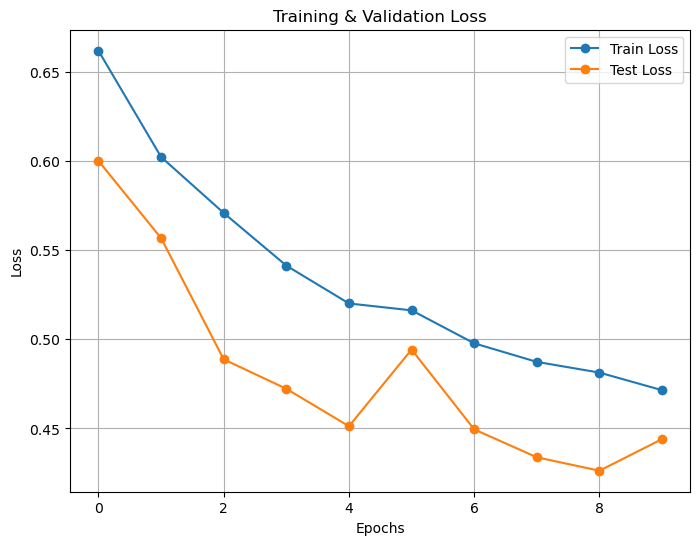

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = pretrained_vit_results["train_loss"]
test_loss = pretrained_vit_results["test_loss"]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Train Loss", marker="o")
plt.plot(test_loss, label="Test Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()
plt.savefig("training_loss_plot.png")

In [40]:
torch.save(pretrained_vit, 'model2_complete.pth')


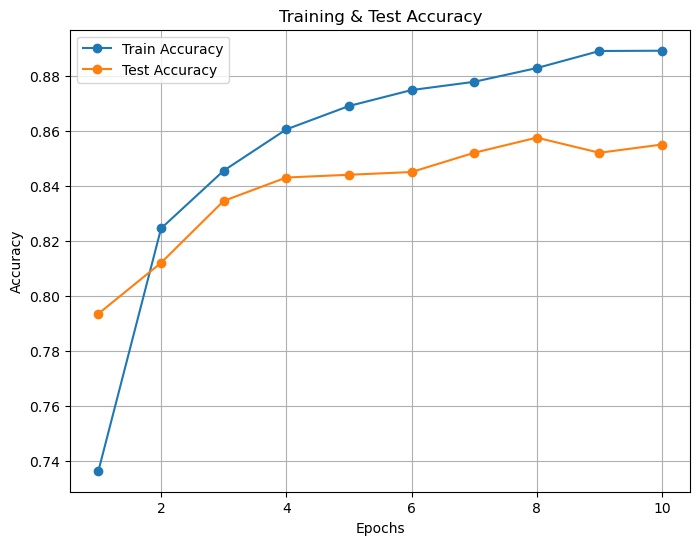

<Figure size 640x480 with 0 Axes>

In [41]:
epochs = list(range(1, 11))  # 10 epochs

# Extracted from your logs
train_accuracies = [0.7364, 0.8245, 0.8455, 0.8605, 0.8690, 0.8748, 0.8778, 0.8828, 0.8890, 0.8891]
test_accuracies = [0.7935, 0.8120, 0.8345, 0.8430, 0.8440, 0.8450, 0.8520, 0.8575, 0.8520, 0.8550]

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, test_accuracies, label="Test Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Test Accuracy")
plt.legend()
plt.grid()
plt.show()
plt.savefig("training_accuracy_plot.png")


In [42]:
# Reload my test dataset 
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from csv_dataset import CSVDataset  # Ensure this class is implemented correctly

# Define transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Reload sampled test dataset
test_df = pd.read_csv("sampled_test.csv")  # Ensure file exists

# Create dataset & dataloader
test_data = CSVDataset("sampled_test.csv", transform=transform)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


In [43]:
# Debug: Check if test_dataloader loads data correctly
data_iter = iter(test_dataloader)
try:
    images, labels = next(data_iter)
    print("Batch shape:", images.shape, labels.shape)
    print("Sample labels:", labels[:10])  # Print first 10 labels
except StopIteration:
    print("Error: test_dataloader is empty! Check your dataset loading.")


Batch shape: torch.Size([32, 3, 224, 224]) torch.Size([32])
Sample labels: tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 1])


Processing Batches: 100%|██████████| 63/63 [02:51<00:00,  2.72s/batch]


<Figure size 600x600 with 0 Axes>

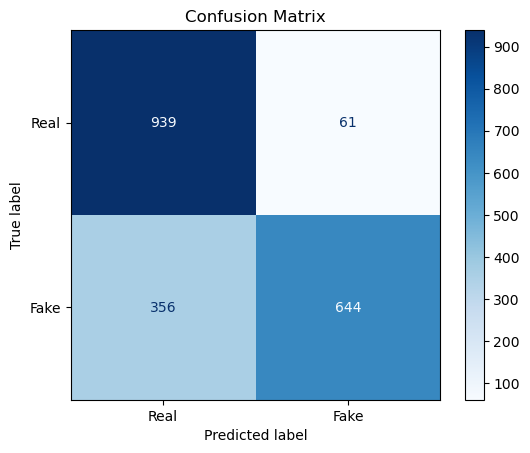

              precision    recall  f1-score   support

        Real       0.73      0.94      0.82      1000
        Fake       0.91      0.64      0.76      1000

    accuracy                           0.79      2000
   macro avg       0.82      0.79      0.79      2000
weighted avg       0.82      0.79      0.79      2000



In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm  # Import tqdm for progress bar

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model_path = "/Users/mandylee/Documents/AI/GenAIProject/MarchRuns/ViT Models/ViT_2/model2_complete.pth"
pretrained_vit = torch.load(model_path, map_location=device, weights_only=False)
pretrained_vit.to(device)
pretrained_vit.eval()

# Get predictions
all_preds, all_labels = [], []

# Add tqdm progress bar
with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc="Processing Batches", unit="batch"):
        images, labels = images.to(device), labels.to(device)
        outputs = pretrained_vit(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Create and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])

# Save the confusion matrix as an image
plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")  # Save as PNG
plt.show()

# Print classification report
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))


In [47]:
# Print and save classification report
report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"], output_dict=True)
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake"]))

# Save classification report as CSV
df_report = pd.DataFrame(report).transpose()
df_report.to_csv("classification_report.csv", index=True)

              precision    recall  f1-score   support

        Real       0.73      0.94      0.82      1000
        Fake       0.91      0.64      0.76      1000

    accuracy                           0.79      2000
   macro avg       0.82      0.79      0.79      2000
weighted avg       0.82      0.79      0.79      2000

